In [44]:
import scvi
import scanpy as sc
import os
import pandas as pd
from scvi.model.utils import mde

##### Put the replicate 2 processed data path here

In [29]:
output_folder = r'/mnt/sata1/Analysis_Alex/timecourse_replicates/analysis/cleaned'

In [30]:
replicates_xenium_data = sc.read(os.path.join(output_folder, 'final_celltyped_and_axes.h5ad'))

/home/amonell/mambaforge/envs/scvi-env/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/amonell/mambaforge/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


##### Put the replicate 1 processed data path here

In [31]:
reference_xenium_data = sc.read('/mnt/sata1/Analysis_Alex/timecourse_final/analysis/cleaned/final_celltyped_and_axes.h5ad')

/home/amonell/mambaforge/envs/scvi-env/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/amonell/mambaforge/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Merging the two objects replicate 1 and replicate 2 together

In [32]:
replicates_xenium_data.obs.index = ['rep2_' + replicates_xenium_data.obs['batch'].values[d] + '_' + replicates_xenium_data.obs.index.values[d] for d in range(len(replicates_xenium_data.obs['batch'].values))]

In [33]:
reference_xenium_data.obs.index = ['rep1_' + reference_xenium_data.obs['batch'].values[d] + '_' + reference_xenium_data.obs.index.values[d] for d in range(len(reference_xenium_data.obs['batch'].values))]

In [34]:
del replicates_xenium_data.uns
del reference_xenium_data.uns

In [35]:
replicate_obs = replicates_xenium_data.obs
reference_obs = reference_xenium_data.obs

In [36]:
replicates_xenium_data.obs = pd.DataFrame(replicates_xenium_data.obs['batch'], index=replicates_xenium_data.obs.index.values)

In [37]:
reference_xenium_data.obs = pd.DataFrame(reference_xenium_data.obs['batch'], index=reference_xenium_data.obs.index.values)

In [38]:
concatenated_xenium = sc.concat([replicates_xenium_data, reference_xenium_data])

Running scvi joint integration on the objects

In [39]:
scvi.model.SCVI.setup_anndata(concatenated_xenium, batch_key="batch", layer="raw")

/home/amonell/mambaforge/envs/scvi-env/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


In [40]:
scvi_ref = scvi.model.SCVI(concatenated_xenium, n_layers=2, n_latent=30, gene_likelihood="nb")
scvi_ref.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 3/3: 100%|██████████| 3/3 [06:35<00:00, 130.38s/it, v_num=1, train_loss_step=105, train_loss_epoch=111]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [06:35<00:00, 131.91s/it, v_num=1, train_loss_step=105, train_loss_epoch=111]


In [42]:
concatenated_xenium.obsm["X_scVI"] = scvi_ref.get_latent_representation()

#### Projecting into UMAP, clustering, and subsetting the data to relevant observations

In [43]:
sc.pp.neighbors(concatenated_xenium, use_rep="X_scVI")


In [45]:
concatenated_xenium.obsm["X_mde"] = mde(concatenated_xenium.obsm["X_scVI"])

In [87]:
observations = pd.concat([replicate_obs[['predicted_longitudinal', 'not_removed_from_longitudinal',
       'Subtype', 'Type',
       'Immunocentric_Type', 'Class', 'leiden', 'epithelial_distance',
       'crypt_villi_axis', 'epithelial_distance_clipped', 'batch']], reference_obs[['predicted_longitudinal', 'not_removed_from_longitudinal', 'Subtype', 'Type',
       'Immunocentric_Type', 'Class', 'leiden', 'epithelial_distance',
       'crypt_villi_axis', 'epithelial_distance_clipped', 'batch']]])

In [88]:
concatenated_xenium.obs = concatenated_xenium.obs.merge(observations, how='left', left_index=True, right_index=True)

In [90]:
sc.tl.leiden(concatenated_xenium)

/home/amonell/mambaforge/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/amonell/mambaforge/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


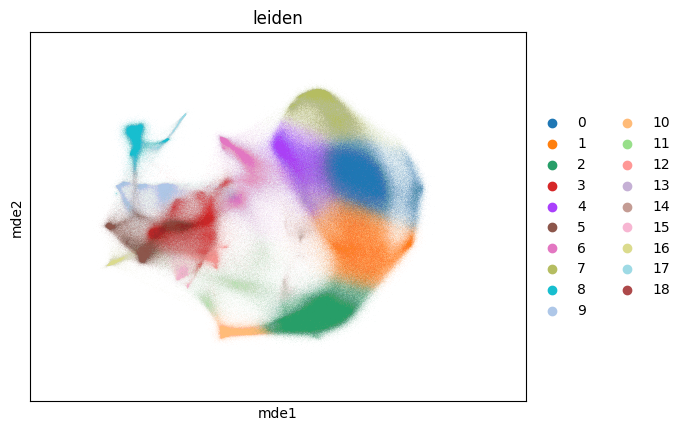

In [91]:
import matplotlib.pyplot as plt
fig = sc.pl.embedding(concatenated_xenium, basis='mde', color='leiden', return_fig=True, vmax=1)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

#### Subclustering all leiden clusters

In [1]:
from tqdm.notebook import tqdm
import numpy as np
def get_celltype(celltype, ad_sp):
    ctype = ad_sp[ad_sp.obs.leiden.isin([celltype])]
    sc.pp.neighbors(ctype, use_rep='X_scVI')
    sc.tl.leiden(ctype, resolution= 1.2)
    sc.tl.umap(ctype)
    return ctype
def reunite_with_ad(ad_sp, subset_ad, celltype):
    new_labels  = []
    subclusters = ad_sp.obs.Sub_leiden.values
    clusters = ad_sp.obs.leiden.values
    idex = ad_sp.obs.index.values
    for i in tqdm(range(len(subclusters))):
        if clusters[i] == celltype:
            new_labels.append(subset_ad.obs.loc[idex[i], :].leiden)
        else:
            new_labels.append(subclusters[i])
    ad_sp.obs.Sub_leiden = new_labels
    return ad_sp
concatenated_xenium.obs['Sub_leiden'] = concatenated_xenium.obs['leiden']
for leiden_to_subset in tqdm(np.unique(concatenated_xenium.obs['leiden'].values)):
    mac = get_celltype(leiden_to_subset, concatenated_xenium)
    mac.obs['leiden'] = [leiden_to_subset + '_' + i for i in mac.obs.leiden]
    concatenated_xenium = reunite_with_ad(concatenated_xenium, mac, leiden_to_subset)

#### Reassigning the cell types of all the replicate 2 samples based on what cell type 1 annotation is most prevalent in each joint cluster 

In [102]:
dictionary_sub = {}
for group in concatenated_xenium.obs.groupby('Sub_leiden'):
    most_common_subtype = group[1]['Subtype'].value_counts().idxmax()
    dictionary_sub[group[0]] = most_common_subtype

/tmp/ipykernel_3189866/132516356.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group in concatenated_xenium.obs.groupby('Sub_leiden'):


In [111]:
reassigned_subtypes = []
for sub in concatenated_xenium.obs['Sub_leiden'].values:
    diction = dictionary_sub.get(sub)
    reassigned_subtypes.append(diction)

In [112]:
concatenated_xenium.obs['New_Subtype'] = reassigned_subtypes

/home/amonell/mambaforge/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/amonell/mambaforge/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


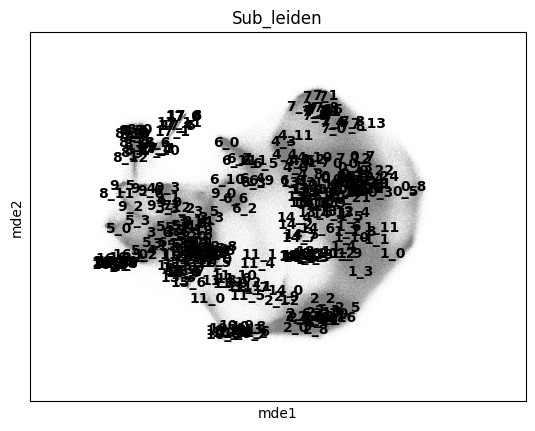

In [115]:
import matplotlib.pyplot as plt
fig = sc.pl.embedding(concatenated_xenium, basis='mde', color='Sub_leiden', legend_loc='on data', return_fig=True, vmax=1)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

/home/amonell/mambaforge/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/amonell/mambaforge/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


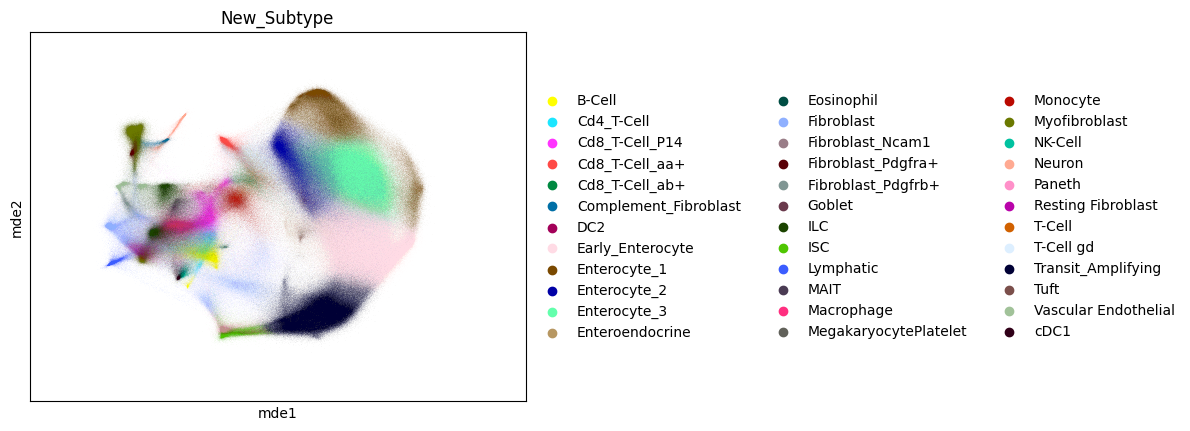

In [114]:
import matplotlib.pyplot as plt
fig = sc.pl.embedding(concatenated_xenium, basis='mde', color='New_Subtype', return_fig=True, vmax=1)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

#### Assiging Type, Class and Immunocentric Type based on heirarchy
##### Put the path to the final replicate 1 adata

In [ ]:
rep1_path = '/mnt/sata1/Analysis_Alex/timecourse_final/analysis/cleaned/final_celltyped_and_axes.h5ad'

In [178]:
types = sc.read(rep1_path)
types_ = pd.crosstab(types.obs['Type'], types.obs['Subtype'])
class_ = pd.crosstab(types.obs['Class'], types.obs['Type'])
immuno_ = pd.crosstab(types.obs['Immunocentric_Type'], types.obs['Subtype'])

/home/amonell/mambaforge/envs/scvi-env/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/amonell/mambaforge/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [180]:

type_dictionary = {}
for i in concatenated_xenium.obs['New_Subtype'].cat.categories:
    type_dictionary[i] = types_.index.values[np.where(types_[i].values > 0)[0]][0]
all_types = []
for k in concatenated_xenium.obs['New_Subtype'].values:
    all_types.append(type_dictionary.get(k))
concatenated_xenium.obs['Type'] = all_types

itype_dictionary = {}
for i in concatenated_xenium.obs['New_Subtype'].cat.categories:
    try:
        itype_dictionary[i] = immuno_.index.values[np.where(immuno_[i].values > 0)[0]][0]
    except:
        print(i)
        #itype_dictionary[i] = 'None'
all_itypes = []
for k in concatenated_xenium.obs['New_Subtype'].values:
    all_itypes.append(itype_dictionary.get(k))
concatenated_xenium.obs['Immunocentric_Type'] = all_itypes

class_dictionary = {}
for i in np.unique(concatenated_xenium.obs['Type'].values):
    class_dictionary[i] = class_.index.values[np.where(class_[i].values > 0)[0]][0]
all_classes = []
for k in concatenated_xenium.obs['Type'].values:
    all_classes.append(class_dictionary.get(k))
concatenated_xenium.obs['Class'] = all_classes

#sc.pl.embedding(concatenated_xenium, basis='mde', color=['New_Subtype', 'Type', 'Class', 'Immunocentric_Type'])

/home/amonell/mambaforge/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/amonell/mambaforge/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


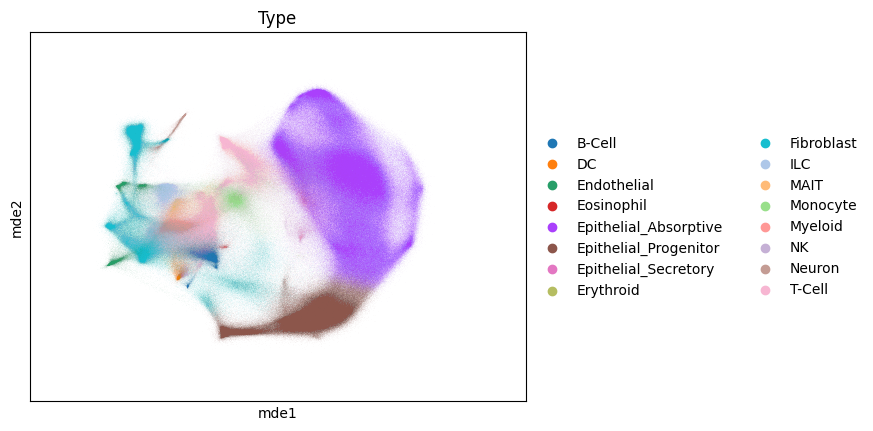

In [184]:
import matplotlib.pyplot as plt
fig = sc.pl.embedding(concatenated_xenium, basis='mde', color='Type', return_fig=True, vmax=1)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

In [186]:
concatenated_xenium.obs['Subtype']= concatenated_xenium.obs['New_Subtype']

In [199]:
first_df = pd.concat([reference_obs, replicate_obs])[['total_transcripts', 'nuclear_transcripts', 'cytoplasmic_transcripts',
       'nuclear_transcript_percentage', 'cell', 'x', 'y', 'predicted_longitudinal', 'not_removed_from_longitudinal','epithelial_distance', 'crypt_villi_axis', 
       'epithelial_distance_clipped']]

In [201]:
concatenated_xenium.obs = concatenated_xenium.obs[['batch', 'leiden', 'Sub_leiden', 'Subtype', 'Type', 'Class', 'Immunocentric_Type']].merge(first_df, how='left', left_index=True, right_index=True)

##### Writing out the object with all replicates

In [202]:
concatenated_xenium.write(r'/mnt/sata1/Analysis_Alex/timecourse_replicates/analysis/cleaned/full_xenium_replicates_and_reference.h5ad')

In [2]:
import scvi
import scanpy as sc
import os
import pandas as pd
from scvi.model.utils import mde

/home/amonell/mambaforge/envs/scvi-env/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/amonell/mambaforge/envs/scvi-env/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [37]:
concatenated_xenium = sc.read(r'/mnt/sata1/Analysis_Alex/timecourse_replicates/analysis/cleaned/full_xenium_replicates_and_reference.h5ad')

/home/amonell/mambaforge/envs/scvi-env/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


#### Some manual correction of cell type clusters

In [40]:
new_cell_types = []
for i in range(len(concatenated_xenium.obs['Subtype'])):
    if (concatenated_xenium.obs['Subtype'].values[i] == 'ILC') & (concatenated_xenium.obs['Sub_leiden'].values[i] in ['3_0', '3_6']):
        new_cell_types.append('NK-Cell')
    elif concatenated_xenium.obs['Subtype'].values[i] == 'ILC':
        new_cell_types.append('ILC')
    elif (concatenated_xenium.obs['Subtype'].values[i] == 'NK-Cell'):
        new_cell_types.append('DC2')
    elif (concatenated_xenium.obs['Sub_leiden'].values[i] in ['11_0']):
        new_cell_types.append('Paneth')
    else:
        new_cell_types.append(concatenated_xenium.obs['Subtype'][i])

/tmp/ipykernel_4192072/1523030049.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_cell_types.append(concatenated_xenium.obs['Subtype'][i])


In [41]:
concatenated_xenium.obs['Subtype'] = new_cell_types

In [43]:
types = sc.read(rep1_path)
types_ = pd.crosstab(types.obs['Type'], types.obs['Subtype'])
class_ = pd.crosstab(types.obs['Class'], types.obs['Type'])
immuno_ = pd.crosstab(types.obs['Immunocentric_Type'], types.obs['Subtype'])

/home/amonell/mambaforge/envs/scvi-env/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


/home/amonell/mambaforge/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [44]:
import numpy as np
type_dictionary = {}
for i in concatenated_xenium.obs['Subtype'].cat.categories:
    type_dictionary[i] = types_.index.values[np.where(types_[i].values > 0)[0]][0]
all_types = []
for k in concatenated_xenium.obs['Subtype'].values:
    all_types.append(type_dictionary.get(k))
concatenated_xenium.obs['Type'] = all_types

itype_dictionary = {}
for i in concatenated_xenium.obs['Subtype'].cat.categories:
    try:
        itype_dictionary[i] = immuno_.index.values[np.where(immuno_[i].values > 0)[0]][0]
    except:
        print(i)
        #itype_dictionary[i] = 'None'
all_itypes = []
for k in concatenated_xenium.obs['Subtype'].values:
    all_itypes.append(itype_dictionary.get(k))
concatenated_xenium.obs['Immunocentric_Type'] = all_itypes

class_dictionary = {}
for i in np.unique(concatenated_xenium.obs['Type'].values):
    class_dictionary[i] = class_.index.values[np.where(class_[i].values > 0)[0]][0]
all_classes = []
for k in concatenated_xenium.obs['Type'].values:
    all_classes.append(class_dictionary.get(k))
concatenated_xenium.obs['Class'] = all_classes

#sc.pl.embedding(concatenated_xenium, basis='mde', color=['Subtype', 'Type', 'Class', 'Immunocentric_Type'])

In [51]:
concatenated_xenium.write(r'/mnt/sata1/Analysis_Alex/timecourse_replicates/analysis/cleaned/full_xenium_replicates_and_reference.h5ad')